In [26]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.pyplot as plt

In [27]:
#conversion degrees <-> radiants
def degtorad(deg):
    return deg*np.pi/180
def radtodeg(rad):
    return rad*180/np.pi

#acollinearity function
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))

#longitudinal missing energy (< 0.6sqrt(s))

#missing momentum vector angle (<16°)

#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events_real(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

def n_events_mc(dfname, df_names, nevents_nom):
    index = df_names.index(dfname)
    return nevents_nom[index]

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/(n_events)

#log likelihood ratio
def LogLR(expBkg, expSig, obs):
    #avoid log of 0 using super small number #hack
    result = obs*np.log(max(expSig+expBkg, 0.000001)) - expSig - obs*np.log(max(expBkg,0.000001))
    return -2*result

In [28]:
#initial definitions

backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb


signals = ['higgs_85','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb

data = ['data']




#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs
nevents_nom = [5940000,200000,81786,294500,29500,196000,3972,3973,3971]

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []  

#integrate luminosity
int_lumi = 176.773 #pb^-1

In [29]:
################################
# creation of all df and lists #
################################



for channel in channels:
    #fill the dataframes
    filename = '../l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
       
    #add acollinearity
    angle = 180*np.pi/180
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))            
    (vars()[dfname])['acoll'] = acollin
        
    
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

In [30]:
#find n of events and weights
sumbkg = 0
ndata = 0

for dfname in df_names:
    index = df_names.index(dfname)
    if bkgsigdata[index] == 'sgn':
        scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
        nevents=((n_events_mc(dfname, df_names, nevents_nom))*scalef)
        print (dfname, nevents)
    elif bkgsigdata[index] == 'bkg':
        scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like(np.linspace(1,n_events_mc(dfname, df_names, nevents_nom), n_events_mc(dfname, df_names, nevents_nom)))
        nevents=((n_events_mc(dfname, df_names, nevents_nom))*scalef)
        sumbkg += nevents
        print (dfname, nevents)
    elif bkgsigdata[index] == 'data':
        ndata=n_events_real(df_list[index])
        print (dfname, ndata)

print('\ntotal bkg: ', sumbkg)
ratio = sumbkg/ndata
print('\ntot ratio: ', ratio)


df_eeqq 2757658.8
df_qq 18030.846
df_wen 512.6417
df_ww 2916.7545
df_zee 592.18955
df_zz 172.35367499999998
df_higgs_85 16.616661999999998
df_higgs_90 11.790759099999999
df_higgs_95 5.886540900000001
df_data 641

total bkg:  2779883.5854249992

tot ratio:  4336.791864937596


weights:



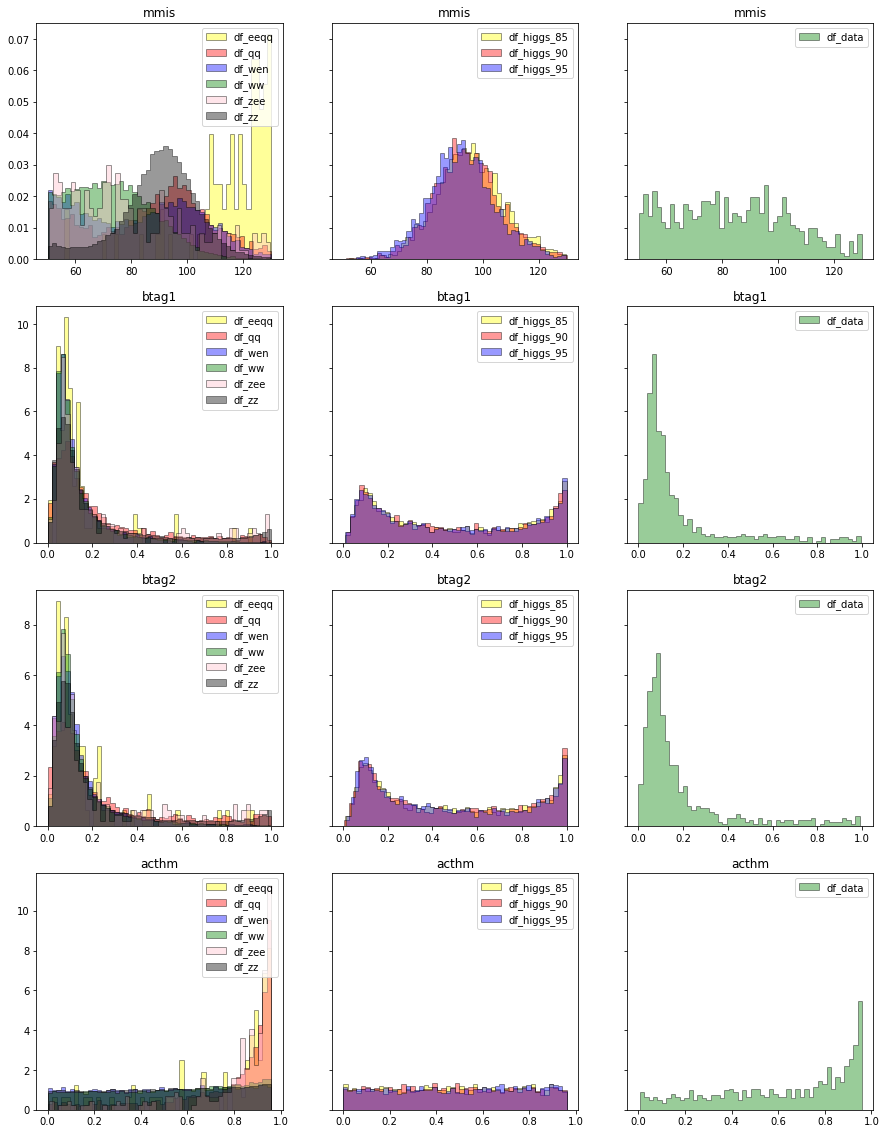

In [31]:
##########################################################
# plot all variables for signal and background (no cuts) #
##########################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['mmis', 'btag1', 'btag2', 'acthm']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink', 'black']
bins = 50

#plot each variable on each row
#left background, right signal(s)

f, axs = plt.subplots(varlength, 3, sharey='row', sharex='row', figsize=(15,varlength*5))

for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)
        
        
        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            axs[index_var,0].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)
            
            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events_mc(dfname, df_names, nevents_nom), n_events_mc(dfname, df_names, nevents_nom)))
            #axs[index_var,0].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
        
        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            axs[index_var,1].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)

            #calculate scale factor (xs) and plot histograms
            scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like(np.linspace(1,n_events_mc(dfname, df_names, nevents_nom), n_events_mc(dfname, df_names, nevents_nom)))
            #axs[index_var,1].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

        #data
        if bkgsigdata[index] == 'data':
            #plot histograms (normalised area to 1)
            axs[index_var,2].hist((df_list[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4, density=True)

            #calculate scale factor (xs) and plot histograms
            #axs[index_var,2].hist(((df_list[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')
    axs[index_var,2].set_title(varname)
    axs[index_var,2].legend(loc='best')

plt.show()

85
3029
7856
26392
232
35972


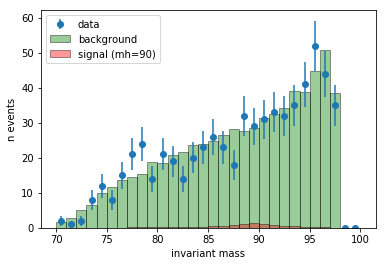

In [32]:
def midpoints_bins(bins):
    binwidth_bins = bins[1]-bins[0]
    midpointlist = []
    for item in range(0, len(bins)-1):
        midpointlist.append(bins[0] + binwidth_bins * (0.5 + item))
    return midpointlist

def binwidth_bins(bins):
    return bins[1]-bins[0]



bins = np.linspace(70,100,31)

signal85_mh = []
signal90_mh = []
signal95_mh = []
backgr_mh = [0]*(len(bins)-1)
data_mh = []

nevents = [0]*len(df_list)

for dfname in df_names:
    index = df_names.index(dfname)
    
    #sum over backgrounds
    if bkgsigdata[index] == 'bkg':
        if(n_events_mc(dfname, df_names, nevents_nom) != 0):
            #calculate scale factor (xs) 
            scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
            weights = scalef*np.ones_like((df_list[index])['fmvis'])
            print(len(weights))
            bkg,bins_bkg,patches_bkg = plt.hist(((df_list[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            backgr_mh = np.add(backgr_mh,bkg)

    #data
    if bkgsigdata[index] == 'data':
        data_histo,bins_data,patches_data = plt.hist(((df_list[index])['fmvis']), bins=bins, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

#clear all plots
plt.clf()



## CONSIDER FOR NOW 90 GEV MH HYPOTHESIS

for dfname in df_names:
    index = df_names.index(dfname)
    #signal with mh=90 GeV
    if dfname == "df_higgs_90":
        scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
        weights = scalef*np.ones_like((df_list[index])['fmvis'])
        sgn_90,bins_sgn_90,patches_sgn_90 = plt.hist(((df_list[index])['fmvis']), bins=bins, weights=weights, color='green', ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

plt.clf()


#plot data
plt.errorbar(midpoints_bins(bins), data_histo, yerr=np.sqrt(data_histo),fmt='o', label='data')
#plot background
plt.bar(midpoints_bins(bins), backgr_mh, width=binwidth_bins(bins),color='green', ec="black", label='background', alpha=0.4)
#plot signal
plt.bar(midpoints_bins(bins), sgn_90, width=binwidth_bins(bins),color='red', ec="black", label='signal (mh=90)', alpha=0.4)
plt.legend(loc="best")
plt.xlabel("invariant mass")
plt.ylabel("n events")
plt.show()
